# Step 1 – Machine Learning Project  
## Credit Card Fraud Detection  

### 1. Introduction  
This project aims to analyze and model a dataset of credit card transactions in order to detect fraudulent operations.  
The dataset contains anonymized features obtained through PCA (V1 to V28), the transaction amount, and the target variable Class (0 = normal, 1 = fraud).

This notebook covers the following tasks:  
1) Descriptive analysis of the dataset  
2) Necessary preprocessing steps  
3) Formalisation of the problem  
4) Baseline model implementation  


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve

df = pd.read_csv("creditcard.csv")
df.head()


,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


## 1. Descriptive Analysis of the Data  

In this section, we explore the structure of the dataset, the number of samples, the statistical properties of the features, and the distribution of the target class as well as the statistical properties, correlations, and class distribution.

In [28]:
# Statistical summary
df.describe()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
count,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06
mean,2.433972e+02,1.798619e+05,8.338831e+05,8.551137e+05,1.100702e+06,1.224996e+06,1.290820e-03,2.514687e-06
std,1.423320e+02,6.038582e+05,2.888243e+06,2.924049e+06,3.399180e+06,3.674129e+06,3.590480e-02,1.585775e-03
min,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.560000e+02,1.338957e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,2.390000e+02,7.487194e+04,1.420800e+04,0.000000e+00,1.327057e+05,2.146614e+05,0.000000e+00,0.000000e+00
75%,3.350000e+02,2.087215e+05,1.073152e+05,1.442584e+05,9.430367e+05,1.111909e+06,0.000000e+00,0.000000e+00
max,7.430000e+02,9.244552e+07,5.958504e+07,4.958504e+07,3.560159e+08,3.561793e+08,1.000000e+00,1.000000e+00


In [29]:
# Checking missing values
df.isnull().sum()

# Calculate missing values in percentage for each column
(df.isnull().sum() / len(df)) * 100

step              0.0
type              0.0
amount            0.0
nameOrig          0.0
oldbalanceOrg     0.0
newbalanceOrig    0.0
nameDest          0.0
oldbalanceDest    0.0
newbalanceDest    0.0
isFraud           0.0
isFlaggedFraud    0.0
dtype: float64

In [30]:
# Count how many duplicated rows exist in the dataset
duplicates = df.duplicated().sum()
print("Number of duplicated rows:", duplicates)

# Remove duplicated rows if any exist
if duplicates > 0:
    df = df.drop_duplicates()
    print("Duplicates removed. New shape:", df.shape)
else:
    print("No duplicates found.")

Number of duplicated rows: 0
No duplicates found.


In [31]:
# Basic info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


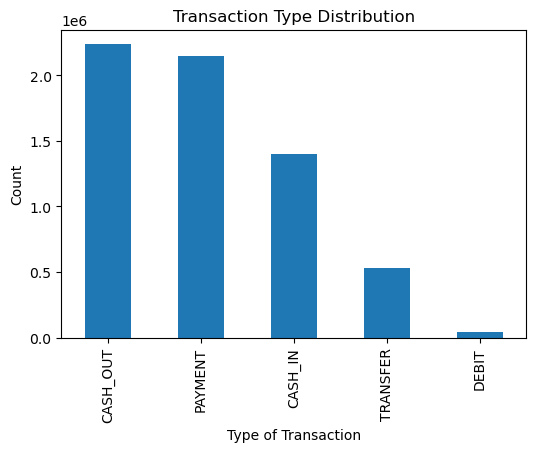

In [32]:
# Count how many transactions exist for each transaction type
df['type'].value_counts()

# Plot distribution of transaction types
df['type'].value_counts().plot(kind='bar', figsize=(6,4))
plt.title("Transaction Type Distribution")
plt.xlabel("Type of Transaction")
plt.ylabel("Count")
plt.show()

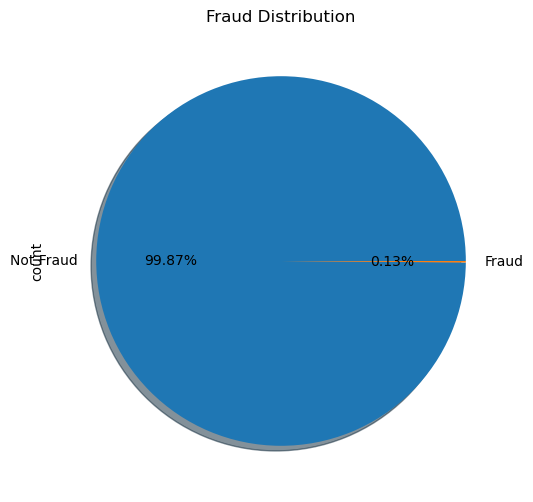

In [33]:
# Show the proportion of fraud vs non-fraud transactions
df['isFraud'].value_counts(normalize=True)

# Plot fraud distribution as a pie chart
df['isFraud'].value_counts().plot(
    kind='pie',
    autopct='%1.2f%%',
    labels=['Not Fraud', 'Fraud'],
    figsize=(6,6),
    shadow=True
)
plt.title("Fraud Distribution")
plt.show()

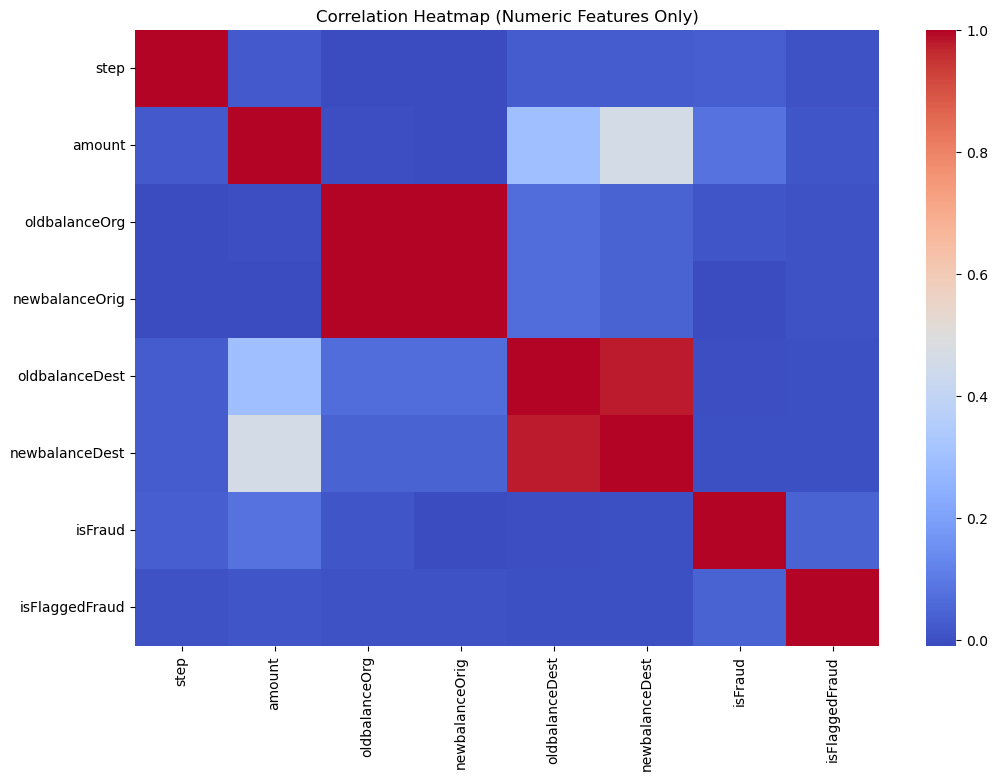

In [34]:
# Select only numerical columns for correlation
numeric_df = df.select_dtypes(include=['int64', 'float64'])

# Compute correlation only on numerical features
plt.figure(figsize=(12,8))
sns.heatmap(numeric_df.corr(), cmap="coolwarm")
plt.title("Correlation Heatmap (Numeric Features Only)")
plt.show()


In [35]:
# Check for negative transaction amounts (should not exist)
df[df['amount'] < 0]

# Remove any transaction with negative amounts
df = df[df['amount'] >= 0]

In [36]:
# Print a simple summary of the cleaned dataset
print("Dataset shape after cleaning:", df.shape)
print("Columns:", df.columns.tolist())

Dataset shape after cleaning: (6362620, 11)
Columns: ['step', 'type', 'amount', 'nameOrig', 'oldbalanceOrg', 'newbalanceOrig', 'nameDest', 'oldbalanceDest', 'newbalanceDest', 'isFraud', 'isFlaggedFraud']


# 2. Pre-processing Steps

In this section, we prepare the PaySim dataset for machine learning.  
The main tasks include:

- Handling categorical variables  
- Scaling numerical variables  
- Selecting relevant features  
- Splitting the dataset into training and testing sets  
- Checking class imbalance  

This preprocessing step ensures that the model in Part 3 can learn correctly.


In [37]:
# Identify categorical columns that need encoding
categorical_cols = df.select_dtypes(include='object').columns
categorical_cols

Index(['type', 'nameOrig', 'nameDest'], dtype='object')

In [38]:
# Apply One-Hot Encoding to categorical column 'type'
# This converts text labels into numerical columns
df_encoded = pd.get_dummies(df, columns=['type'], drop_first=True)

df_encoded.head()

,step,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER
0,1,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0,False,False,True,False
1,1,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0,False,False,True,False
2,1,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0,False,False,False,True
3,1,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0,True,False,False,False
4,1,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0,False,False,True,False


## 2.1 Scaling Numerical Variables

The amount, oldbalanceOrg, and newbalanceOrig columns contain monetary values with large ranges.  
Scaling helps the model learn more efficiently.


In [39]:
# List of numeric columns to scale
scale_cols = ["amount", "oldbalanceOrg", "newbalanceOrig", 
              "oldbalanceDest", "newbalanceDest"]

scaler = StandardScaler()
df_encoded[scale_cols] = scaler.fit_transform(df_encoded[scale_cols])

df_encoded.head()

,step,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER
0,1,-0.281560,C1231006815,-0.229810,-0.237622,M1979787155,-0.323814,-0.333411,0,0,False,False,True,False
1,1,-0.294767,C1666544295,-0.281359,-0.285812,M2044282225,-0.323814,-0.333411,0,0,False,False,True,False
2,1,-0.297555,C1305486145,-0.288654,-0.292442,C553264065,-0.323814,-0.333411,1,0,False,False,False,True
3,1,-0.297555,C840083671,-0.288654,-0.292442,C38997010,-0.317582,-0.333411,1,0,True,False,False,False
4,1,-0.278532,C2048537720,-0.274329,-0.282221,M1230701703,-0.323814,-0.333411,0,0,False,False,True,False


## 2.2 Selecting Input Features and Target Variable

The target variable is isFraud.  
We split the dataset into:

- X => the features (input)
- y => the target (output)

In [ ]:
# Remove useless ID columns that cannot be used by the model (important for part 4)
df_encoded = df_encoded.drop(columns=["nameOrig", "nameDest"], errors='ignore')

# X contains all features except target
X = df_encoded.drop("isFraud", axis=1)

# y contains the target variable
y = df_encoded["isFraud"]

## 2.3 Train/Test Split

We split the dataset using a stratified method to preserve the proportion of fraud vs non-fraud.

In [41]:
# Stratified split ensures same proportion of fraud/non-fraud in train and test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

print("Training shape:", X_train.shape)
print("Testing shape:", X_test.shape)

Training shape: (4453834, 13)
Testing shape: (1908786, 13)


## 2.4 Class Imbalance Check

Fraud detection datasets are usually extremely imbalanced.  
Before building the model, we check how unbalanced isFraud is.

In [42]:
# Percentage of fraud in the dataset
fraud_percentage = y.value_counts(normalize=True) * 100
fraud_percentage

isFraud
0    99.870918
1     0.129082
Name: proportion, dtype: float64

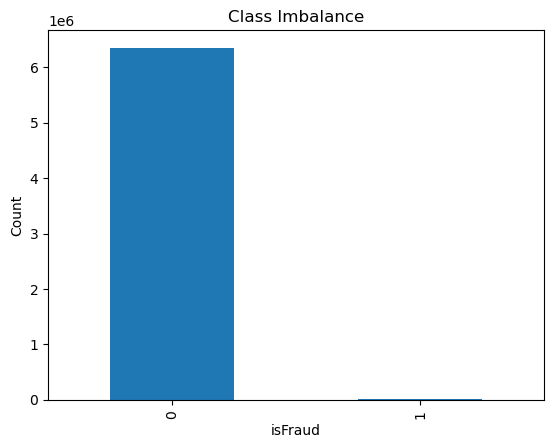

In [43]:
# Plot class imbalance
y.value_counts().plot(kind='bar')
plt.title("Class Imbalance")
plt.xlabel("isFraud")
plt.ylabel("Count")
plt.show()

# 3. Problem Formalisation

## 3.1 Business Context  
Financial fraud is a major challenge in the digital payments industry.  
Banks, online services, and fintech companies must detect fraudulent transactions in real time to reduce financial losses, protect customers, and maintain trust.

The PaySim dataset simulates real-world mobile money transactions based on private data from a financial system in Africa.  
It includes different types of transactions (CASH_IN, CASH_OUT, TRANSFER, PAYMENT, etc.) and indicates whether each operation is fraudulent.

---

## 3.2 Machine Learning Problem  
The goal of this project is to build a model capable of **classifying transactions as fraud or non-fraud**.

This is a **binary classification problem** where:

- **0 => legitimate transaction**  
- **1 => fraudulent transaction**

We use the following inputs (features):

- Transaction step (time)  
- Amount of the transaction  
- Transaction type  
- Balance before and after the operation (origin & destination accounts)  
- Other financial indicators  

The output is the variable:  
**isFraud => the fraud label**

---

## 3.3 Challenges  
Fraud detection comes with several challenges:

### • Strong class imbalance  
Fraud cases represent **less than 0.2%** of all transactions.  
This makes the problem difficult because models tend to predict only the majority class.

### • Complex financial behavior  
Fraudulent transactions are not directly linked to simple variables such as amount or balance.  
They require analyzing **patterns and interactions** between several features.

### • High false-negative cost  
Missing a fraud (classifying a fraudulent transaction as legitimate) is far more costly than a false alarm.  
Models must prioritize **recall** and **precision for the fraud class**.

---

## 3.4 Objective of the Baseline Model  
The purpose of Step 1 is to create a **simple baseline model** that:

- Uses the cleaned and preprocessed dataset  
- Learns how to classify fraud based on the available features  
- Provides initial performance metrics  
- Serves as a reference for improvement in Step 2 and Step 3  

This baseline will allow us to compare later models such as:  
- Random Forest  
- Gradient Boosting  
- XGBoost  
- Neural Networks  


# 4. Baseline Model

The goal of the baseline model is to create a simple first version of a fraud detection classifier.  
This model will serve as a reference to evaluate future improvements in Step 2 and Step 3.

Because the dataset is highly imbalanced, we train models that can handle class imbalance using:

- Class weights  
- Evaluation metrics adapted to fraud detection (Recall, F1-score, ROC-AUC)

Two baseline models are used:
1. Logistic Regression (simple linear model)
2. Random Forest (basic non-linear model)

These models help us understand the dataset's difficulty and give us a starting point.

In [ ]:
# Create the logistic regression model with class balancing
log_model = LogisticRegression(class_weight="balanced", max_iter=1000)

# Train the model
log_model.fit(X_train, y_train)

# Predictions
y_pred_log = log_model.predict(X_test)
y_prob_log = log_model.predict_proba(X_test)[:, 1]  # probability of fraud

# Print classification performance
print("=== Logistic Regression Report ===")
print(classification_report(y_test, y_pred_log))

print("ROC-AUC Score:", roc_auc_score(y_test, y_prob_log))

=== Logistic Regression Report ===
              precision    recall  f1-score   support

           0       1.00      0.95      0.97   1906322
           1       0.02      0.96      0.05      2464

    accuracy                           0.95   1908786
   macro avg       0.51      0.95      0.51   1908786
weighted avg       1.00      0.95      0.97   1908786

ROC-AUC Score: 0.9908867055080582


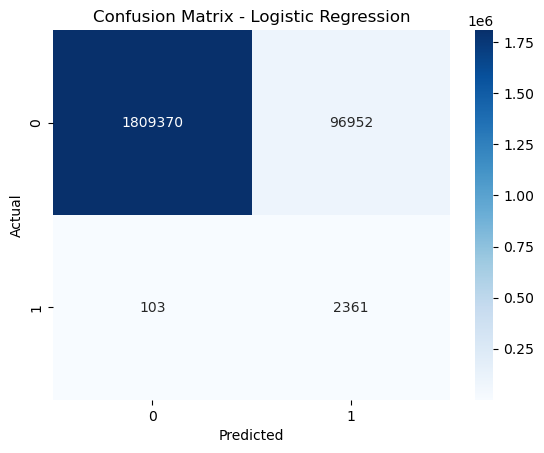

In [55]:
# Compute confusion matrix
cm_log = confusion_matrix(y_test, y_pred_log)

# Visualize confusion matrix
sns.heatmap(cm_log, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix - Logistic Regression")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

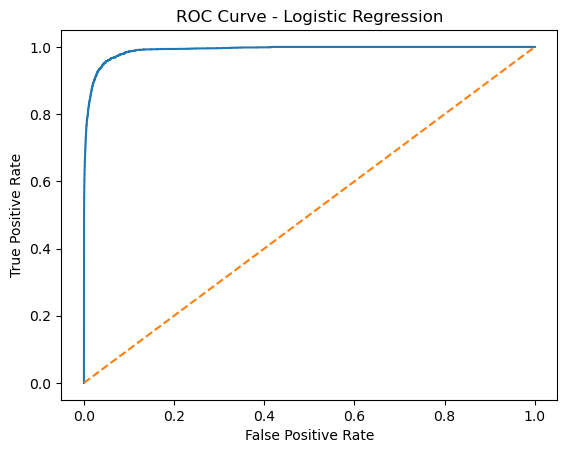

In [56]:
# Compute ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_prob_log)

plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], '--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Logistic Regression")
plt.show()

### Conclusion – Logistic Regression Baseline Model

The logistic regression model provides a strong baseline for fraud detection.  
It achieves an excellent ROC-AUC score of 0.99, showing that it can clearly
distinguish between fraudulent and legitimate transactions.  
The recall for the fraud class is very high (0.96), meaning the model is able
to correctly detect most fraudulent cases, which is crucial in financial applications.

However, the precision for fraud remains low due to the strong class imbalance
in the dataset, which leads the model to generate many false alarms.  
Despite this limitation, the logistic regression model offers a reliable and interpretable
baseline on which more advanced models can later be compared.